## Ideas for expansion
Model the effects of "option 1" in the conference draft on all house districts.

### Data
- House districts
- SLUDs
- SMA
- Honolulu zoning
- Hazards?

### Outputs
- % of house district in each SLUD
- % of house district in SMA
- % of house district zoned residential (- country)

### Process
- Import all data and project to albers hi
#### SLUD
- house overlay SLUD intersection
- calculate areas
- calculate % and save to table
- generate map
- save map as image
- filter to urban only
#### SMA
- house overlay SMA union
- calculate areas
- calculate % and save to table
- generate map
- save map as image
- clip house to no SMA
#### Residential
- use existing zoning files
- filter to residential only
#### Combined result
- Intersect urban SLUD, not in SMA, residential only
- calculate areas
- calculate % and save to table
- generate map
- save map as image

### Bill provisions
#### Option 1:
 (1)  Districts that authorize at least two accessory dwelling units, or the reasonable equivalent, for residential use per each permitted existing single-family dwelling on a residentially zoned lot; provided that these districts shall be:

          (A)  Consistent with the county's comprehensive general plan;

          (B)  Reasonably distributed throughout the county's various regional planning areas; and

          (C)  Estimated to add development potential equivalent to half of the county's projected five-year demand of needed housing units for ownership or rental as stated in the 2019 Hawaii housing planning study; and
#### Exceptions:
     (i)  This section shall not apply to:

     (1)  Any area outside of the urban district established by chapter 205;

     (2)  County powers within special management areas delineated pursuant to chapter 205A; and

     (3)  Any area within an urban district that a county deems to be at high risk of a natural hazard such as flooding, lava, or fire, as determined by the most current data and maps issued by a federal or state department or agency.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [2]:
house = gpd.read_file('./data/lege/Hawaii_State_House_Districts_2022.geojson')

# keep county, state_house, house_name, geometry
drop_cols = ['objectid', 'house_id',
       'house_abbr', 'st_areashape', 'st_perimetershape']
house = house.drop(drop_cols, axis=1)

# Project to NAD 1983 Albers Hawaii for area calculations https://epsg.io/102007 -- 41s
original_crs = house['geometry'].crs

albers_hi = '+proj=aea +lat_0=13 +lon_0=-157 +lat_1=8 +lat_2=18 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs'
house['geometry'] = house['geometry'].to_crs(albers_hi)

# calculate house area
house['house_area'] = house.area

# project back to other crs
house['geometry'] = house['geometry'].to_crs(original_crs)

## SLUD
- house overlay SLUD intersection
- calculate areas
- calculate % and save to table
- generate map
- save map as image
- filter to urban only

In [10]:
# import data
# FIXME this SLUD file only has Oahu
slud = gpd.read_file('./data/State_Land_Use_Districts.geojson')


c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [11]:
house_by_slud = house.overlay(slud, how = 'intersection')

In [12]:
# project result to albers
house_by_slud['geometry'] = house_by_slud['geometry'].to_crs(albers_hi)

# calculate slud areas in house districts
house_by_slud['slud_in_house_area'] = house_by_slud.geometry.area

# Aggregate to see slud % by 
house_slud_pct = house_by_slud.groupby(['state_house', 'lud_code']).agg({
    'house_name': 'first',
    'county': 'first',
    'slud_in_house_area': 'sum',
    'house_area': 'first'
})

# calculate % area for each slud
house_slud_pct['slud_pct'] = house_slud_pct['slud_in_house_area'] / house_slud_pct['house_area']

# round for clean analysis
house_slud_pct['slud_pct'] = round(house_slud_pct['slud_pct'], 3) * 100

# export to file
house_slud_pct.to_csv('./output/house_slud_pct.csv')

In [15]:
# filter to urban district and reproject to prep intersection
slud = slud[slud['lud_code'] == 1]
slud['geometry'] = slud['geometry'].to_crs(original_crs)

<Axes: >

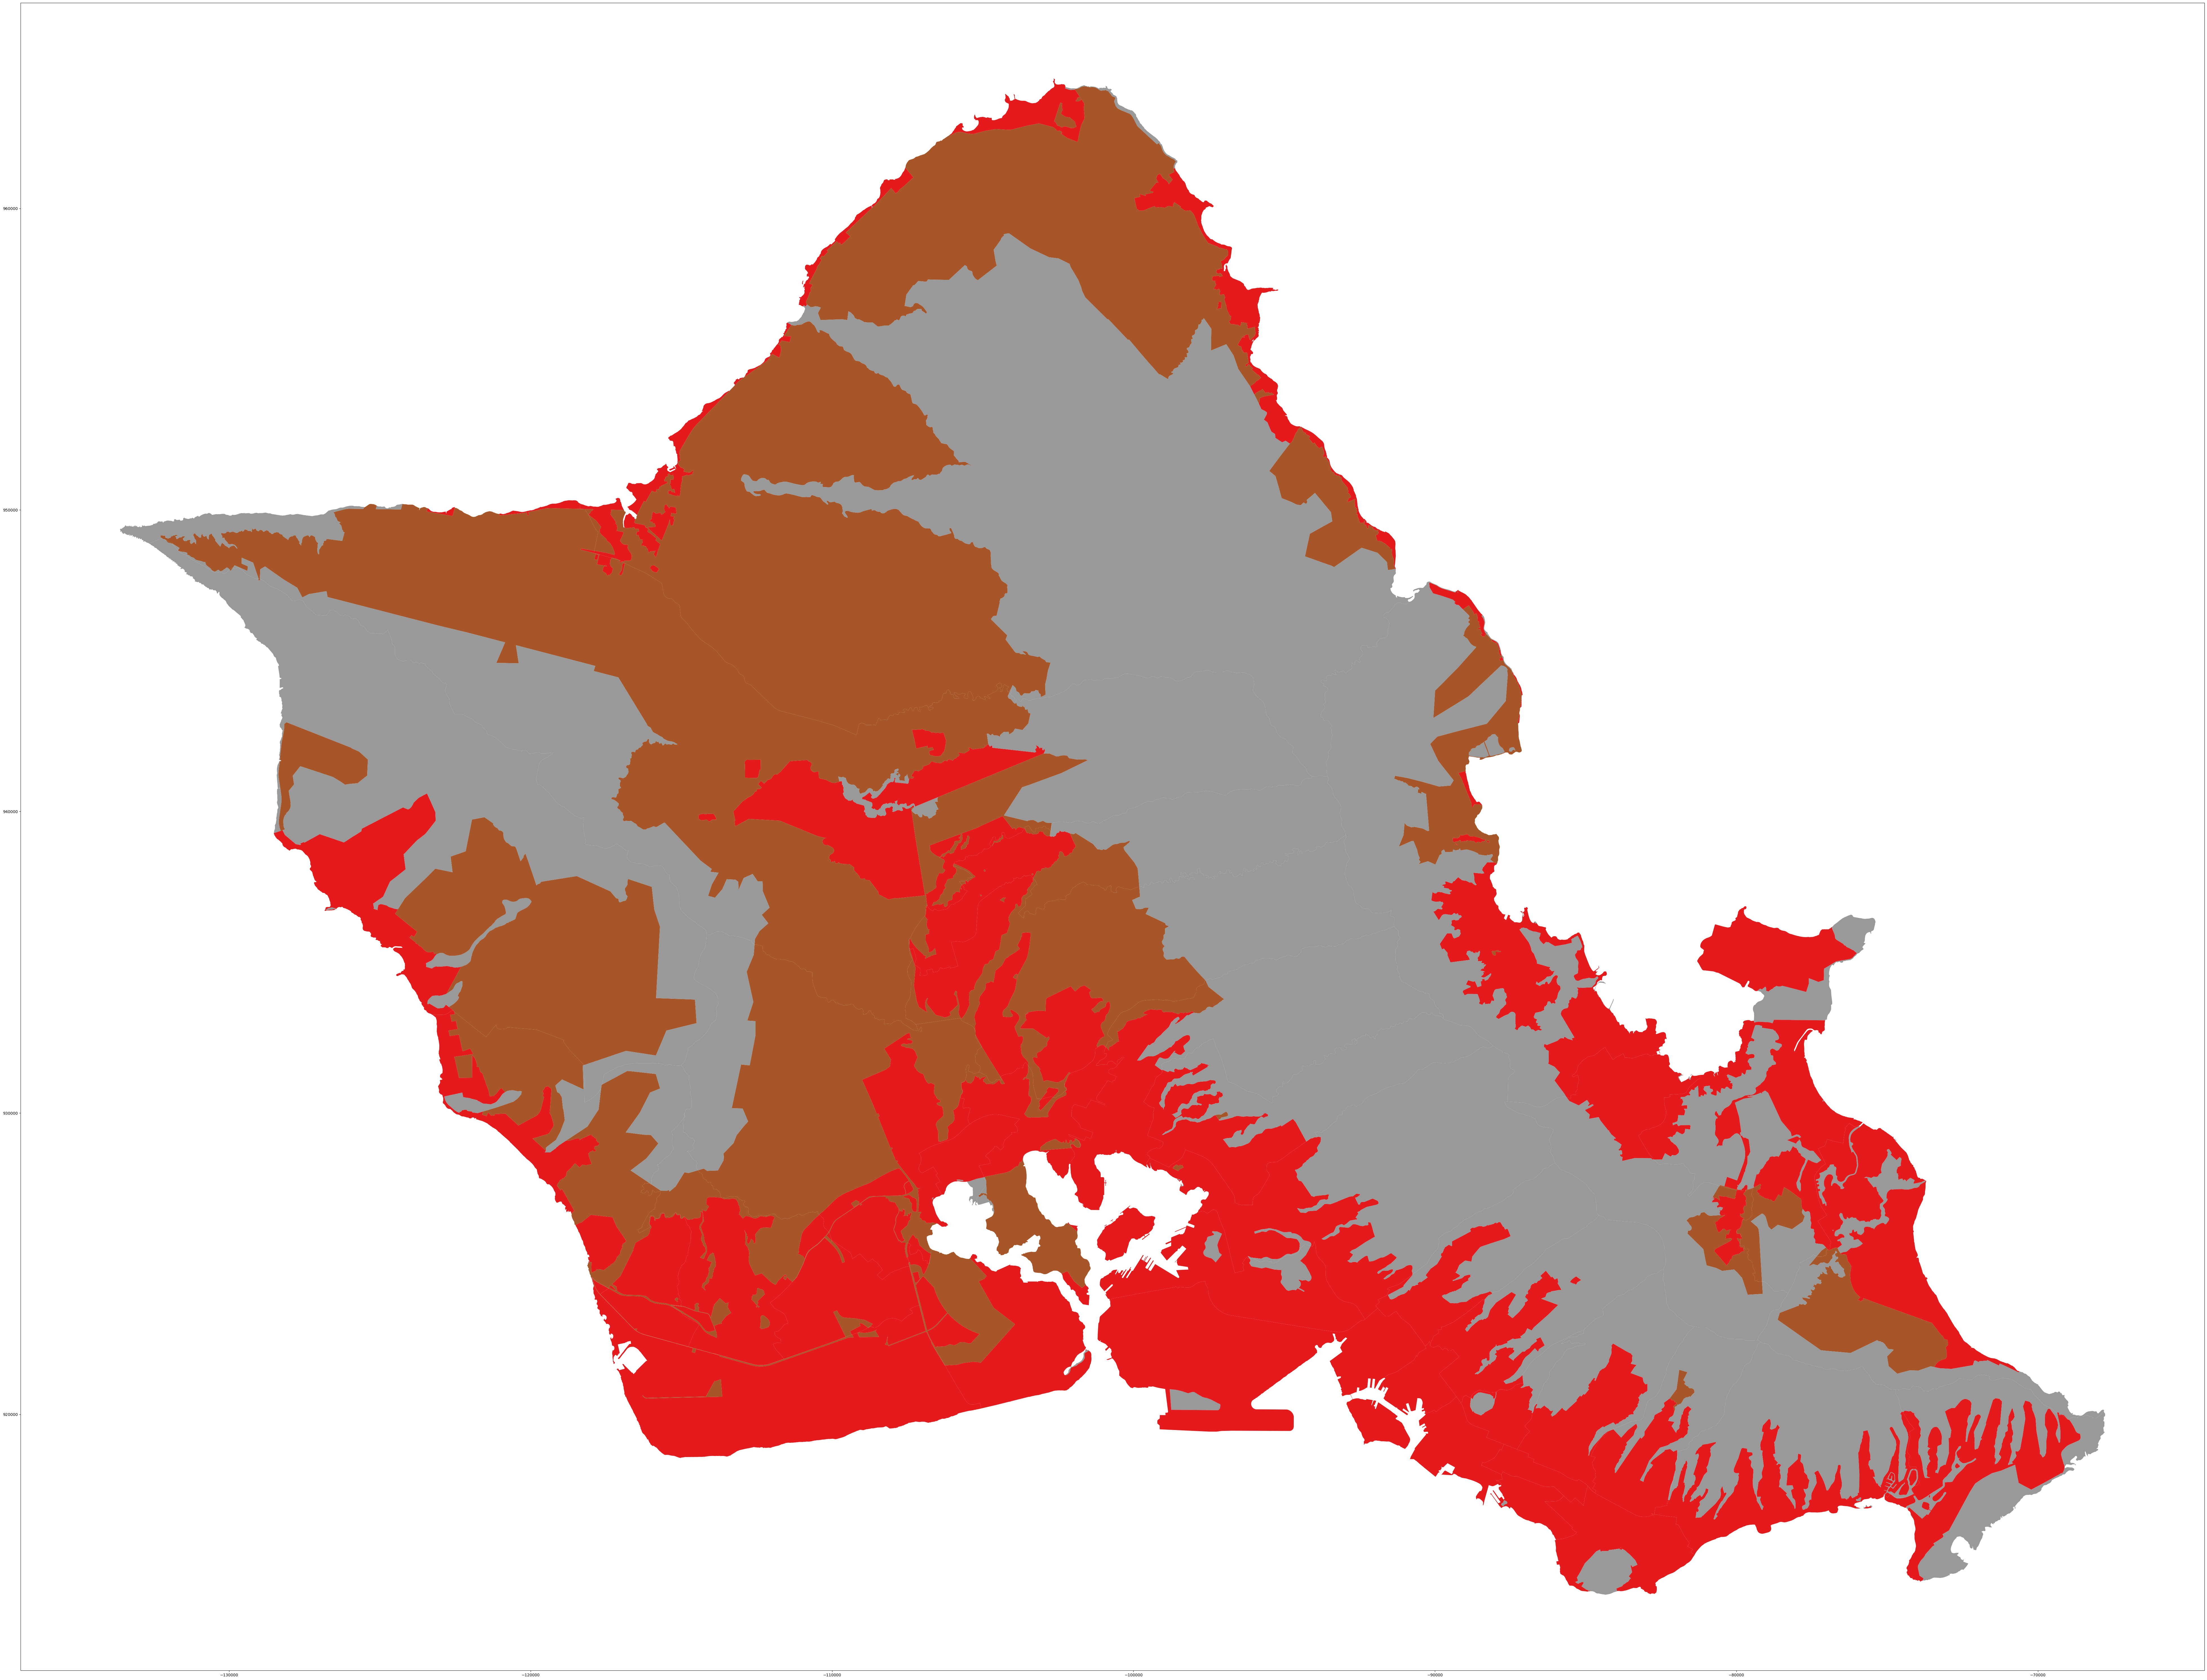

In [14]:
house_by_slud.plot(column='lud_code', 
           cmap='Set1',
           figsize=(100, 100))

# SMA

In [16]:
sma = gpd.read_file('./data/Special_Management_Areas_(SMA).geojson')

In [17]:
house_by_sma = house.overlay(sma, how = 'union')

In [18]:
house_by_sma.head()

,county,state_house,house_name,house_area,objectid,smarea,acres,st_areashape,st_perimetershape,geometry
0,HAWAII,H01,State House District 1,2.024909e+09,11.0,1.0,97581.01365,3.948964e+08,1.187721e+06,"MULTIPOLYGON (((-155.66601 20.09965, -155.6657..."
1,HAWAII,H02,State House District 2,5.677006e+07,11.0,1.0,97581.01365,3.948964e+08,1.187721e+06,"POLYGON ((-155.08710 19.72788, -155.08707 19.7..."
2,HAWAII,H03,State House District 3,2.370837e+08,11.0,1.0,97581.01365,3.948964e+08,1.187721e+06,"MULTIPOLYGON (((-155.06698 19.74378, -155.0668..."
3,HAWAII,H04,State House District 4,7.324968e+08,11.0,1.0,97581.01365,3.948964e+08,1.187721e+06,"MULTIPOLYGON (((-154.94210 19.60027, -154.9420..."
4,HAWAII,H05,State House District 5,4.696085e+09,11.0,1.0,97581.01365,3.948964e+08,1.187721e+06,"MULTIPOLYGON (((-155.61253 18.97072, -155.6125..."
